In [2]:
import os
import json
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import torch
from ultralytics import YOLO
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

torch.cuda.is_available(), torch.version.cuda, torch.__version__

PyTorch версия: 2.5.1+cu121
CUDA: True
GPU: NVIDIA GeForce RTX 4060


(True, '12.1', '2.5.1+cu121')

📂 Загружаем аннотации...
Загружено 7988 изображений
Загружено 38642 аннотаций
Категорий объектов: 8

📋 Категории объектов:
  ID 2140001: vibration_damper
  ID 2150001: festoon_insulators
  ID 2280011: polymer_insulators
  ID 2160001: traverse
  ID 2220001: nest
  ID 2280000: bad_insulator
  ID 2280001: damaged_insulator
  ID 2270001: safety_sign+


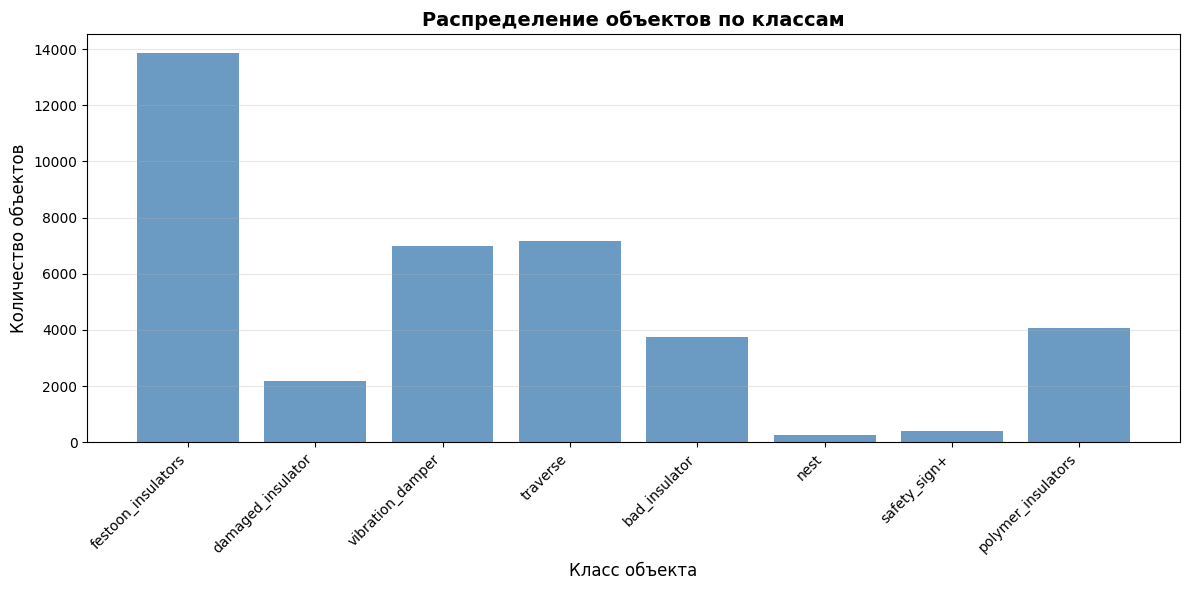

In [3]:
DATA_DIR = Path("insulators")
IMAGES_DIR = DATA_DIR / "images"
ANNOTATIONS_FILE = DATA_DIR / "annotation_data.json"
CATEGORIES_FILE = DATA_DIR / "coco_categories.json"

# Загружаем JSON файлы
print("📂 Загружаем аннотации...")
with open(ANNOTATIONS_FILE, 'r', encoding='utf-8') as f:
    annotations_data = json.load(f)

with open(CATEGORIES_FILE, 'r', encoding='utf-8') as f:
    categories_data = json.load(f)

print(f"Загружено {len(annotations_data.get('images', []))} изображений")
print(f"Загружено {len(annotations_data.get('annotations', []))} аннотаций")
print(f"Категорий объектов: {len(categories_data.get('categories', []))}")

categories = {cat['id']: cat['name'] for cat in categories_data['categories']}
print("\n📋 Категории объектов:")
for cat_id, cat_name in categories.items():
    print(f"  ID {cat_id}: {cat_name}")

category_counts = {}
for ann in annotations_data['annotations']:
    cat_id = ann['category_id']
    cat_name = categories[cat_id]
    category_counts[cat_name] = category_counts.get(cat_name, 0) + 1

plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='steelblue', alpha=0.8)
plt.xlabel('Класс объекта', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)
plt.title('Распределение объектов по классам', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
def coco_to_yolo_bbox(bbox, img_width, img_height):
    """
    Конвертирует bbox из формата COCO в формат YOLO

    COCO: [x_min, y_min, width, height] - абсолютные пиксели
    YOLO: [x_center, y_center, width, height] - относительные координаты (0-1)

    Пример:
    Изображение 1000x800 пикселей
    COCO bbox: [100, 200, 50, 60]
    YOLO bbox: [0.125, 0.2875, 0.05, 0.075]
    """
    x_min, y_min, width, height = bbox

    # Центр объекта
    x_center = x_min + width / 2
    y_center = y_min + height / 2

    # Нормализуем к диапазону 0-1
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height

    return [x_center, y_center, width, height]


Структура папок YOLO

In [5]:
YOLO_DIR = Path("insulators_yolo")
YOLO_DIR.mkdir(exist_ok=True)

for split in ['train', 'val']:
    (YOLO_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

print("Done")

Done


Создаем словари для быстрого доступа

In [6]:
images_dict = {img['id']: img for img in annotations_data['images']}

# Группируем аннотации по изображениям
annotations_by_image = {}
for ann in annotations_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_by_image:
        annotations_by_image[img_id] = []
    annotations_by_image[img_id].append(ann)

print(f"Обработано {len(images_dict)} изображений")
print(f"Сгруппировано аннотаций для {len(annotations_by_image)} изображений")

Обработано 7988 изображений
Сгруппировано аннотаций для 7984 изображений


Разделение на train/val 80/20

In [7]:
train_files = set()
val_files = set()

train_dir = IMAGES_DIR / 'train'
val_dir = IMAGES_DIR / 'val'

if train_dir.exists():
    for img_file in train_dir.glob('*'):
        if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            train_files.add(img_file.name)

if val_dir.exists():
    for img_file in val_dir.glob('*'):
        if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            val_files.add(img_file.name)

print(f"Train: {len(train_files)} изображений")
print(f"Val: {len(val_files)} изображений")

Train: 5514 изображений
Val: 1932 изображений


In [8]:
file_to_split = {}
for fname in train_files:
    file_to_split[fname] = 'train'
for fname in val_files:
    file_to_split[fname] = 'val'


In [9]:
print("\nДИАГНОСТИКА:")
print(f"Путь: {IMAGES_DIR}")
print(f"Существует: {IMAGES_DIR.exists()}")

# Смотрим, что внутри
if IMAGES_DIR.exists():
    subdirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
    print(f"\n📁 Найдено подпапок: {len(subdirs)}")

    for subdir in subdirs[:3]:  # Показываем первые 3
        files = list(subdir.glob('*'))
        print(f"  - {subdir.name}: {len(files)} файлов")
        if files:
            print(f"    Примеры: {[f.name for f in files[:2]]}")

# Проверяем первые записи в аннотациях
print(f"\nПервые 3 file_name:")
for i, img_info in enumerate(list(images_dict.values())[:3]):
    print(f"  {i+1}. {img_info['file_name']}")


ДИАГНОСТИКА:
Путь: insulators\images
Существует: True

📁 Найдено подпапок: 2
  - train: 5514 файлов
    Примеры: ['000000795_jpeg.rf.fdcd7abe4699b8b8a885c984df895841.jpg', '000000986_jpeg.rf.4a0108399c0bb5bc19471755ba4e4148.jpg']
  - val: 1932 файлов
    Примеры: ['170903--2-_JPG.rf.174da06b77ffb1379a221a03ed3ed599.jpg', '20221210_092345_jpg.rf.22adcae3bda7ed30226d14fcc52b420a.jpg']

Первые 3 file_name:
  1. BAD INSULATOR DETECTION.V11I.COCO/000000795_jpeg.rf.fdcd7abe4699b8b8a885c984df895841.jpg
  2. BAD INSULATOR DETECTION.V11I.COCO/000000986_jpeg.rf.4a0108399c0bb5bc19471755ba4e4148.jpg
  3. BAD INSULATOR DETECTION.V11I.COCO/000001268_JPG.rf.ce5d0b856461fd688829b89438107a6a.jpg


Конвертация и копирование файлов

In [10]:
category_id_to_yolo = {cat_id: idx for idx, cat_id in enumerate(sorted(categories.keys()))}

successful_conversions = 0
failed_conversions = 0
failed_files = []

for img_id, img_info in tqdm(images_dict.items(), desc="Конвертация"):
    # Определяем имя файла
    file_name = img_info['file_name']

    # Если file_name содержит путь (train/file.jpg или val/file.jpg), берем только имя
    base_name = Path(file_name).name

    # Определяем split
    if base_name not in file_to_split:
        failed_conversions += 1
        failed_files.append(file_name)
        continue

    split = file_to_split[base_name]

    # Путь к исходному файлу
    source_image_path = IMAGES_DIR / split / base_name

    if not source_image_path.exists():
        failed_conversions += 1
        failed_files.append(file_name)
        continue

    # Копируем изображение
    dest_image_path = YOLO_DIR / split / 'images' / base_name
    shutil.copy(source_image_path, dest_image_path)

    # Создаем .txt файл с аннотациями
    label_file = YOLO_DIR / split / 'labels' / (Path(base_name).stem + '.txt')

    img_width = img_info['width']
    img_height = img_info['height']

    # Получаем все аннотации для этого изображения
    image_annotations = annotations_by_image.get(img_id, [])

    with open(label_file, 'w') as f:
        for ann in image_annotations:
            category_id = ann['category_id']
            yolo_class_id = category_id_to_yolo[category_id]

            # Конвертируем bbox
            coco_bbox = ann['bbox']
            yolo_bbox = coco_to_yolo_bbox(coco_bbox, img_width, img_height)

            # Записываем в формате YOLO
            f.write(f"{yolo_class_id} {' '.join(map(str, yolo_bbox))}\n")

    successful_conversions += 1

print(f"\nУспешно: {successful_conversions} изображений")
print(f"Ошибок: {failed_conversions}")

Конвертация: 100%|██████████| 7988/7988 [01:06<00:00, 120.69it/s]


Успешно: 7451 изображений
Ошибок: 537


Создаем конфигурационный файл data.yaml

In [11]:
data_yaml_content = f"""# Конфигурация датасета для детекции объектов на ЛЭП
path: {YOLO_DIR.absolute()}
train: train/images
val: val/images

# Количество классов
nc: {len(categories)}

# Названия классов
names:
"""

# Добавляем названия классов в правильном порядке
for yolo_id in range(len(categories)):
    # Находим соответствующий COCO ID
    coco_id = [k for k, v in category_id_to_yolo.items() if v == yolo_id][0]
    class_name = categories[coco_id]
    data_yaml_content += f"  {yolo_id}: {class_name}\n"

# Сохраняем файл
data_yaml_path = YOLO_DIR / "data.yaml"
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write(data_yaml_content)

print("Создан файл data.yaml")
print("\nСодержимое:")
print(data_yaml_content)

Создан файл data.yaml

Содержимое:
# Конфигурация датасета для детекции объектов на ЛЭП
path: c:\Users\HappyUser\Desktop\ai\insulators_yolo
train: train/images
val: val/images

# Количество классов
nc: 8

# Названия классов
names:
  0: vibration_damper
  1: festoon_insulators
  2: traverse
  3: nest
  4: safety_sign+
  5: bad_insulator
  6: damaged_insulator
  7: polymer_insulators



In [12]:
import albumentations as A
from collections import Counter, defaultdict

print("АУГМЕНтация\n")

# Определяем целевое количество для каждого класса
# Будем стремиться к ~7000-8000 объектов на класс (половина от максимума)
TARGET_COUNT = 7000

# Подсчитываем текущее количество объектов по классам
class_object_counts = Counter()
class_image_counts = defaultdict(list)  # класс -> список img_id с этим классом

for img_id, img_info in images_dict.items():
    image_annotations = annotations_by_image.get(img_id, [])

    # Какие классы есть на этом изображении
    classes_in_image = set()
    for ann in image_annotations:
        cat_id = ann['category_id']
        class_object_counts[cat_id] += 1
        classes_in_image.add(cat_id)

    # Добавляем изображение в список для каждого класса
    for cat_id in classes_in_image:
        class_image_counts[cat_id].append(img_id)

print("Дефолт распределение:\n")
for cat_id, cat_name in sorted(categories.items()):
    obj_count = class_object_counts[cat_id]
    img_count = len(class_image_counts[cat_id])
    print(f"  {cat_name:30s}: {obj_count:5d} объектов на {img_count:4d} изображениях")

# Определяем, сколько нужно сгенерировать для каждого класса
augmentation_needed = {}
for cat_id, cat_name in categories.items():
    current_count = class_object_counts[cat_id]
    if current_count < TARGET_COUNT:
        # Сколько раз нужно повторить изображения с этим классом
        multiplier = int(TARGET_COUNT / max(current_count, 1))
        augmentation_needed[cat_id] = max(1, multiplier - 1)  # -1 потому что оригиналы уже есть
    else:
        augmentation_needed[cat_id] = 0

print(f"\nМножетели:\n")
for cat_id, cat_name in sorted(categories.items()):
    multiplier = augmentation_needed[cat_id]
    if multiplier > 0:
        print(f"  {cat_name:30s}: x{multiplier + 1} (добавим {multiplier} копий)")
    else:
        print(f"  {cat_name:30s}: не требуется")


АУГМЕНтация

Дефолт распределение:

  vibration_damper              :  6969 объектов на 1886 изображениях
  festoon_insulators            : 13846 объектов на 6653 изображениях
  traverse                      :  7151 объектов на 3576 изображениях
  nest                          :   264 объектов на  259 изображениях
  safety_sign+                  :   414 объектов на  387 изображениях
  bad_insulator                 :  3753 объектов на 2941 изображениях
  damaged_insulator             :  2184 объектов на 1582 изображениях
  polymer_insulators            :  4061 объектов на 1527 изображениях

Множетели:

  vibration_damper              : x2 (добавим 1 копий)
  festoon_insulators            : не требуется
  traverse                      : не требуется
  nest                          : x26 (добавим 25 копий)
  safety_sign+                  : x16 (добавим 15 копий)
  bad_insulator                 : x2 (добавим 1 копий)
  damaged_insulator             : x3 (добавим 2 копий)
  polymer_insulato

In [13]:
augmentation_pipelines = [
    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.Blur(blur_limit=3, p=0.3),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])),

    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.8),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.CLAHE(clip_limit=2.0, p=0.5),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])),

    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(p=0.3),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])),

    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.7),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])),
]

print("Создано 4 варианта аугментации")

Создано 4 варианта аугментации


In [14]:
YOLO_DIR_AUG = Path("insulators_yolo_augmented")
if YOLO_DIR_AUG.exists():
    shutil.rmtree(YOLO_DIR_AUG)

for split in ['train', 'val']:
    (YOLO_DIR_AUG / split / 'images').mkdir(parents=True, exist_ok=True)
    (YOLO_DIR_AUG / split / 'labels').mkdir(parents=True, exist_ok=True)

# Сначала копируем ВСЕ оригинальные данные
print("📋 Копируем оригинальные данные...")

original_train_dir = IMAGES_DIR / 'train'
original_val_dir = IMAGES_DIR / 'val'

# Создаём маппинг категорий
category_id_to_yolo = {cat_id: idx for idx, cat_id in enumerate(sorted(categories.keys()))}

# Создаём индекс файлов
file_to_split = {}
for split, split_dir in [('train', original_train_dir), ('val', original_val_dir)]:
    if split_dir.exists():
        for img_file in split_dir.glob('*'):
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                file_to_split[img_file.name.lower()] = (img_file, split)

print(f"✅ Проиндексировано {len(file_to_split)} оригинальных файлов")

# Конвертируем оригинальные данные
successful_original = 0
failed_original = 0

for img_id, img_info in tqdm(images_dict.items(), desc="Оригинальные"):
    file_name = img_info['file_name']
    base_name = Path(file_name).name
    
    lookup_key = base_name.lower()
    
    if lookup_key not in file_to_split:
        failed_original += 1
        continue
    
    source_image_path, split = file_to_split[lookup_key]
    
    # Копируем изображение
    dest_image_path = YOLO_DIR_AUG / split / 'images' / source_image_path.name
    shutil.copy(source_image_path, dest_image_path)
    
    # Создаём label файл
    label_file = YOLO_DIR_AUG / split / 'labels' / (source_image_path.stem + '.txt')
    
    img_width = img_info['width']
    img_height = img_info['height']
    
    image_annotations = annotations_by_image.get(img_id, [])
    
    with open(label_file, 'w') as f:
        for ann in image_annotations:
            category_id = ann['category_id']
            yolo_class_id = category_id_to_yolo[category_id]
            coco_bbox = ann['bbox']
            yolo_bbox = coco_to_yolo_bbox(coco_bbox, img_width, img_height)
            f.write(f"{yolo_class_id} {' '.join(map(str, yolo_bbox))}\n")
    
    successful_original += 1

print(f"\n✅ Оригинальных файлов скопировано: {successful_original}")
print(f"❌ Не найдено: {failed_original}")

📋 Копируем оригинальные данные...
✅ Проиндексировано 7446 оригинальных файлов


Оригинальные: 100%|██████████| 7988/7988 [00:08<00:00, 887.61it/s] 


✅ Оригинальных файлов скопировано: 7451
❌ Не найдено: 537


In [15]:
augmented_count = 0
augmentation_stats = Counter()

# Обрабатываем только train split для аугментации
for cat_id, multiplier in augmentation_needed.items():
    if multiplier == 0:
        continue
    
    cat_name = categories[cat_id]
    print(f"\n🔄 Аугментация класса: {cat_name} (множитель x{multiplier})...")
    
    # Получаем все изображения с этим классом в train
    train_images_with_class = [
        img_id for img_id in class_image_counts[cat_id]
        if img_id in images_dict
    ]
    
    # Фильтруем только те, которые есть физически
    available_images = []
    for img_id in train_images_with_class:
        img_info = images_dict[img_id]
        file_name = img_info['file_name']
        base_name = Path(file_name).name
        lookup_key = base_name.lower()
        
        if lookup_key in file_to_split:
            source_path, split = file_to_split[lookup_key]
            if split == 'train':  # Аугментируем только train
                available_images.append((img_id, source_path))
    
    print(f"  📊 Доступно {len(available_images)} изображений для аугментации")
    
    # Генерируем копии
    for copy_idx in range(multiplier):
        for img_id, source_path in tqdm(available_images, 
                                        desc=f"  Копия {copy_idx + 1}/{multiplier}",
                                        leave=False):
            
            img_info = images_dict[img_id]
            img_width = img_info['width']
            img_height = img_info['height']
            
            # Загружаем изображение
            image = cv2.imread(str(source_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Получаем аннотации в формате COCO
            image_annotations = annotations_by_image.get(img_id, [])
            bboxes = []
            class_labels = []
            
            for ann in image_annotations:
                bbox = ann['bbox']  # [x, y, w, h] в пикселях
                bboxes.append(bbox)
                class_labels.append(category_id_to_yolo[ann['category_id']])
            
            if not bboxes:
                continue
            
            # Применяем аугментацию
            aug_pipeline = augmentation_pipelines[copy_idx % len(augmentation_pipelines)]
            
            try:
                augmented = aug_pipeline(
                    image=image,
                    bboxes=bboxes,
                    class_labels=class_labels
                )
                
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['class_labels']
                
                # Сохраняем аугментированное изображение
                new_name = f"{source_path.stem}_aug{cat_id}_{copy_idx}_{augmented_count}"
                aug_image_path = YOLO_DIR_AUG / 'train' / 'images' / f"{new_name}.jpg"
                aug_label_path = YOLO_DIR_AUG / 'train' / 'labels' / f"{new_name}.txt"
                
                # Сохраняем изображение
                aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(aug_image_path), aug_image_bgr)
                
                # Сохраняем аннотации в формате YOLO
                with open(aug_label_path, 'w') as f:
                    for bbox, label in zip(aug_bboxes, aug_labels):
                        # bbox в формате COCO [x, y, w, h]
                        yolo_bbox = coco_to_yolo_bbox(bbox, img_width, img_height)
                        f.write(f"{label} {' '.join(map(str, yolo_bbox))}\n")
                
                augmented_count += 1
                augmentation_stats[cat_name] += 1
                
            except Exception as e:
                # Некоторые аугментации могут не сработать (например, если bbox выходит за границы)
                continue

print(f"\n✅ АУГМЕНТАЦИЯ ЗАВЕРШЕНА!")
print(f"📊 Создано {augmented_count} новых изображений\n")
print("📋 Статистика по классам:")
for cat_name, count in augmentation_stats.most_common():
    print(f"  {cat_name:30s}: +{count} изображений")


🔄 Аугментация класса: vibration_damper (множитель x1)...
  📊 Доступно 1010 изображений для аугментации



🔄 Аугментация класса: polymer_insulators (множитель x1)...
  📊 Доступно 969 изображений для аугментации



🔄 Аугментация класса: nest (множитель x25)...
  📊 Доступно 248 изображений для аугментации



🔄 Аугментация класса: bad_insulator (множитель x1)...
  📊 Доступно 1454 изображений для аугментации



🔄 Аугментация класса: damaged_insulator (множитель x2)...
  📊 Доступно 1445 изображений для аугментации



🔄 Аугментация класса: safety_sign+ (множитель x15)...
  📊 Доступно 125 изображений для аугментации



✅ АУГМЕНТАЦИЯ ЗАВЕРШЕНА!
📊 Создано 10929 новых изображений

📋 Статистика по классам:
  nest                          : +5700 изображений
  safety_sign+                  : +1470 изображений
  damaged_insulator             : +1338 изображений
  bad_insulator                 : +994 изображений
  polymer_insulators            : +719 изображений
  vibration_damper              : +708 изображений


In [16]:
for split in ['train', 'val']:
    images_count = len(list((YOLO_DIR_AUG / split / 'images').glob('*')))
    labels_count = len(list((YOLO_DIR_AUG / split / 'labels').glob('*.txt')))
    print(f"{split.upper():5s}: {images_count} изображений, {labels_count} файлов аннотаций")

# Подсчитываем объекты в финальном датасете
print("\n📋 Приблизительное распределение (оригинал + аугментация):")
for cat_id, cat_name in sorted(categories.items()):
    original = class_object_counts[cat_id]
    augmented = augmentation_stats.get(cat_name, 0) * (original / len(class_image_counts.get(cat_id, [1])))
    total_approx = original + augmented
    print(f"  {cat_name:30s}: ~{int(total_approx):5d} объектов")

print("\n💡 Датасет теперь более сбалансирован!")

# %% [markdown]
# ### 📝 Создаём data.yaml для аугментированного датасета

# %%
# Создаём data.yaml
data_yaml_content = f"""# Конфигурация АУГМЕНТИРОВАННОГО датасета для детекции объектов на ЛЭП
path: {YOLO_DIR_AUG.absolute()}
train: train/images
val: val/images

# Количество классов
nc: {len(categories)}

# Названия классов
names:
"""

for yolo_id in range(len(categories)):
    coco_id = [k for k, v in category_id_to_yolo.items() if v == yolo_id][0]
    class_name = categories[coco_id]
    data_yaml_content += f"  {yolo_id}: {class_name}\n"

data_yaml_path_aug = YOLO_DIR_AUG / "data.yaml"
with open(data_yaml_path_aug, 'w', encoding='utf-8') as f:
    f.write(data_yaml_content)

print("✅ Создан файл data.yaml для аугментированного датасета")
print(f"📍 Путь: {data_yaml_path_aug}")

TRAIN: 16443 изображений, 16443 файлов аннотаций
VAL  : 1932 изображений, 1932 файлов аннотаций

📋 Приблизительное распределение (оригинал + аугментация):
  vibration_damper              : ~ 9585 объектов
  festoon_insulators            : ~13846 объектов
  traverse                      : ~ 7151 объектов
  nest                          : ~ 6074 объектов
  safety_sign+                  : ~ 1986 объектов
  bad_insulator                 : ~ 5021 объектов
  damaged_insulator             : ~ 4031 объектов
  polymer_insulators            : ~ 5973 объектов

💡 Датасет теперь более сбалансирован!
✅ Создан файл data.yaml для аугментированного датасета
📍 Путь: insulators_yolo_augmented\data.yaml


Инициализация YOLOv8

In [17]:
model = YOLO('yolov8m.pt')

print("Модель YOLOv8l загружена")
print(f"Параметров в модели: ~3.2М")

Модель YOLOv8l загружена
Параметров в модели: ~3.2М


In [ ]:
results = model.train(
    data=str(data_yaml_path_aug),
    epochs=100,
    imgsz=640,
    batch=16,  # Уменьшено для модели m
    patience=30,
    save=True,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=8,
    project='runs/detect',
    name='insulator_augmented',
    exist_ok=True,
    
    # Оптимизированные параметры
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=4.0,
    
    # МЕНЬШЕ аугментации (уже применили заранее)
    hsv_h=0.01,
    hsv_s=0.5,
    hsv_v=0.3,
    degrees=10,
    translate=0.1,
    scale=0.3,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0,  # Уменьшили
    mixup=0.0,   # Выключили
    copy_paste=0.0,  # Выключили
    
    close_mosaic=10,
)


Ultralytics 8.3.229  Python-3.12.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=insulators_yolo_augmented\data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.02, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=insulator_augmented, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspec

In [19]:
best_model_path = Path('runs/detect/insulator_detection/weights/best.pt')
if best_model_path.exists():
    best_model = YOLO(best_model_path)
    print(f"Загружена лучшая модель: {best_model_path}")
else:
    best_model = model
    print("Используем последнюю версию модели")

Используем последнюю версию модели


In [20]:
print("\n🔍 Валидация модели...")
metrics = best_model.val()

print("\n📊 РЕЗУЛЬТАТЫ:")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")

if metrics.box.map50 >= 0.85:
    print("\nЗаебись.")
elif metrics.box.map50 >= 0.7:
    print("\nНорм.")
else:
    print(f"\nmAP50 = {metrics.box.map50:.4f} < 0.7")
    print("Хуетень")



🔍 Валидация модели...
Ultralytics 8.3.229  Python-3.12.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 650.4607.1 MB/s, size: 125.5 KB)
val: Scanning C:\Users\HappyUser\Desktop\ai\insulators_yolo_augmented\val\labels.cache... 1932 images, 0 backgrounds, 42 corrupt: 100% ━━━━━━━━━━━━ 1932/1932 1.9Mit/s 0.0s
val: C:\Users\HappyUser\Desktop\ai\insulators_yolo_augmented\val\images\Disk_Missing--10-_JPG.rf.1a495315fcba8dcd8fc34d650d5f6bb5.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0101442]
val: C:\Users\HappyUser\Desktop\ai\insulators_yolo_augmented\val\images\Disk_Missing--16-_JPG.rf.9bc33b44c24cca3615b2690ff002a65b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.2031009]
val: C:\Users\HappyUser\Desktop\ai\insulators_yolo_augmented\val\images\Disk_Missing--4-_JPG.rf.8547f36e

Ultralytics 8.3.229  Python-3.12.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 54.9100.7 MB/s, size: 831.5 KB)
val: Scanning C:\Users\HappyUser\Desktop\ai\insulators_yolo\val\labels... 1932 images, 0 backgrounds, 42 corrupt: 100% ━━━━━━━━━━━━ 1932/1932 613.4it/s 3.1s0.1s
val: C:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\Disk_Missing--10-_JPG.rf.1a495315fcba8dcd8fc34d650d5f6bb5.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0101442]
val: C:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\Disk_Missing--16-_JPG.rf.9bc33b44c24cca3615b2690ff002a65b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.2031009]
val: C:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\Disk_Missing--4-_JPG.rf.8547f36ed795b7eff75283ef0fe4f066.jpg: ignoring corrupt image/label: non-n

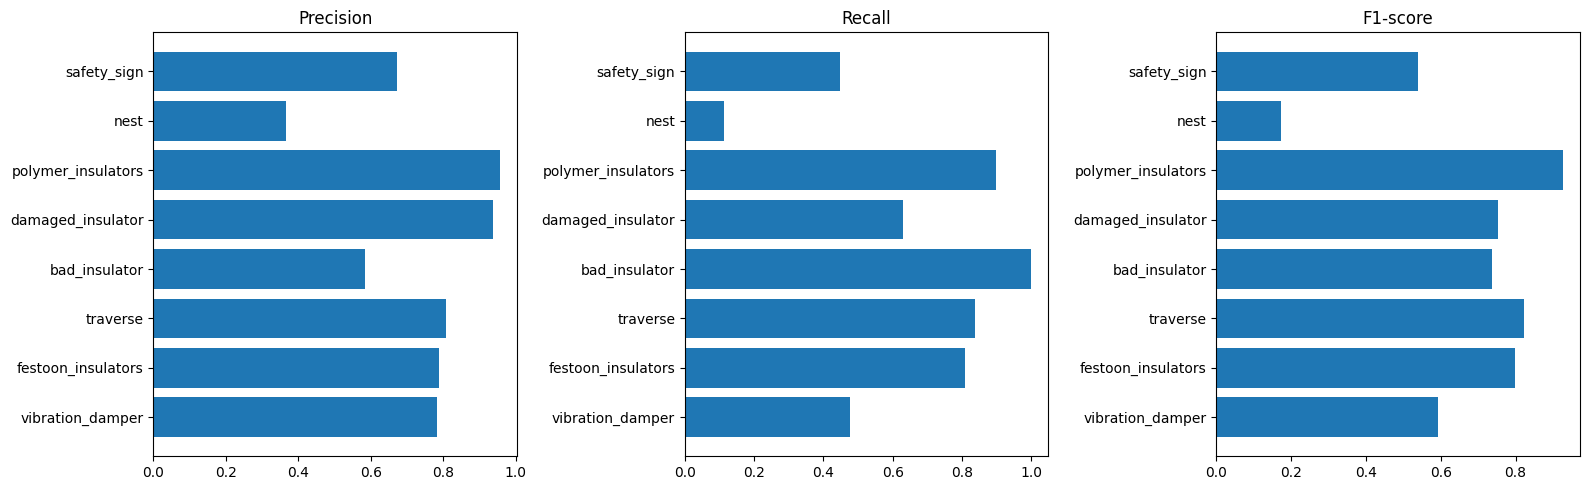

AttributeError: 'list' object has no attribute 'confusion_matrix'

In [22]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# =========================
# 1. Классы
# =========================

categories = {
    0: "vibration_damper",
    1: "festoon_insulators",
    2: "traverse",
    3: "bad_insulator",
    4: "damaged_insulator",
    5: "polymer_insulators",
    6: "nest",
    7: "safety_sign"
}

# =========================
# 2. Модель
# =========================

model = YOLO("runs/detect/insulator_augmented/weights/best.pt")

# =========================
# 3. Валидация
# =========================

metrics = model.val(
    data="insulators_yolo/data.yaml",
    split='val',
    save_json=False,
    verbose=True
)

# =========================
# 4. Основные метрики
# =========================

p = np.array(metrics.box.p)
r = np.array(metrics.box.r)
f1 = np.array(metrics.box.f1)

map50 = metrics.box.map50
map95 = metrics.box.map

df = pd.DataFrame({
    "Класс": list(categories.values()),
    "Precision": p,
    "Recall": r,
    "F1": f1
})

print(df)
print("\n==== MAP ====")
print("mAP@0.5 =", map50)
print("mAP@0.5:0.95 =", map95)
print("============\n")

# =========================
# 5. Bar charts
# =========================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].barh(df["Класс"], df["Precision"])
axes[0].set_title("Precision")

axes[1].barh(df["Класс"], df["Recall"])
axes[1].set_title("Recall")

axes[2].barh(df["Класс"], df["F1"])
axes[2].set_title("F1-score")

plt.tight_layout()
plt.show()

# =========================
# 6. CONFUSION MATRIX (работает)
# =========================

cm = metrics.curves.confusion_matrix  # <-- здесь!

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories.values(),
    yticklabels=categories.values()
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# =========================
# 7. ROC-кривые (доступны)
# =========================

plt.figure(figsize=(9, 7))
for i, name in categories.items():
    roc = metrics.curves.roc[i]
    plt.plot(roc.fpr, roc.tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.grid(True)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curves")
plt.show()


In [23]:
def visualize_predictions(image_path, predictions, save_path=None):
    """
    Визуализирует результаты детекции
    """
    # Загружаем изображение
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Рисуем bounding boxes
    for pred in predictions:
        x1, y1, x2, y2 = map(int, pred['bbox'])
        confidence = pred['confidence']
        class_name = pred['class']

        # Цвет в зависимости от класса
        color = plt.cm.tab10(hash(class_name) % 10)[:3]
        color = tuple(int(c * 255) for c in color)

        # Рисуем bbox
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # Текст с классом и уверенностью
        label = f"{class_name} {confidence:.2f}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (x1, y1 - h - 10), (x1 + w, y1), color, -1)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 255, 255), 1, cv2.LINE_AA)

    # Показываем
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Обнаружено объектов: {len(predictions)}', fontsize=14, fontweight='bold')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()


Тестирование на 5 изображениях...

Обрабатываем: 170903--2-_JPG.rf.174da06b77ffb1379a221a03ed3ed599.jpg

image 1/1 c:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\170903--2-_JPG.rf.174da06b77ffb1379a221a03ed3ed599.jpg: 480x480 1 nest, 9.8ms
Speed: 4.2ms preprocess, 9.8ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 480)


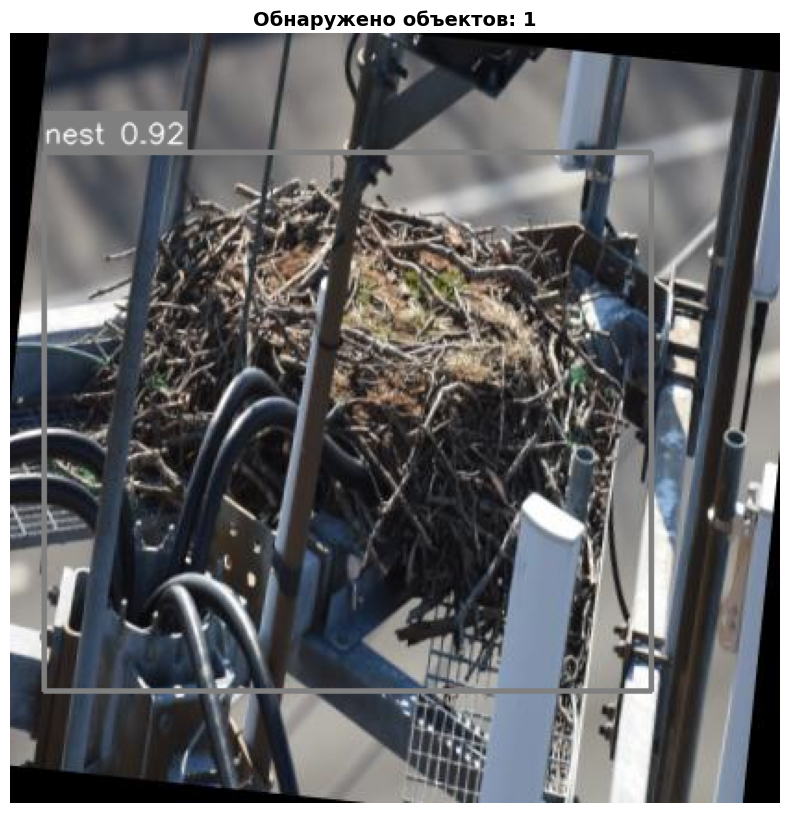

Найдено объектов: 1

Обрабатываем: 20221210_092345_jpg.rf.22adcae3bda7ed30226d14fcc52b420a.jpg

image 1/1 c:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\20221210_092345_jpg.rf.22adcae3bda7ed30226d14fcc52b420a.jpg: 480x480 1 festoon_insulators, 2 bad_insulators, 29.2ms
Speed: 1.3ms preprocess, 29.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 480)


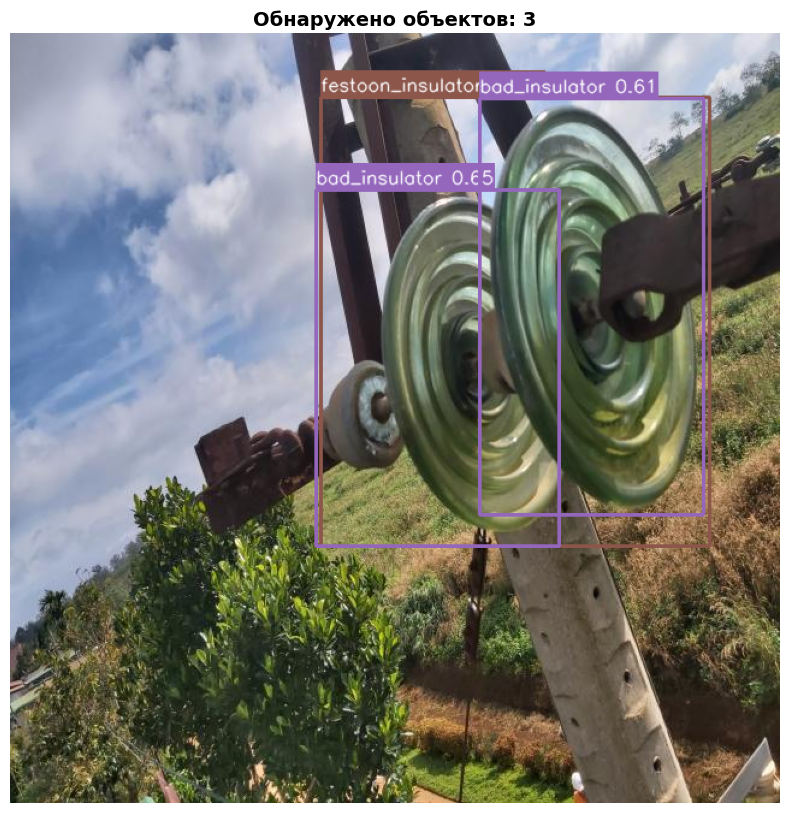

Найдено объектов: 3

Обрабатываем: 20221210_093252_jpg.rf.efa5eedfb91024c5e9baa6cd55ffb44e.jpg

image 1/1 c:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\20221210_093252_jpg.rf.efa5eedfb91024c5e9baa6cd55ffb44e.jpg: 480x480 2 festoon_insulatorss, 2 bad_insulators, 31.5ms
Speed: 1.3ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 480)


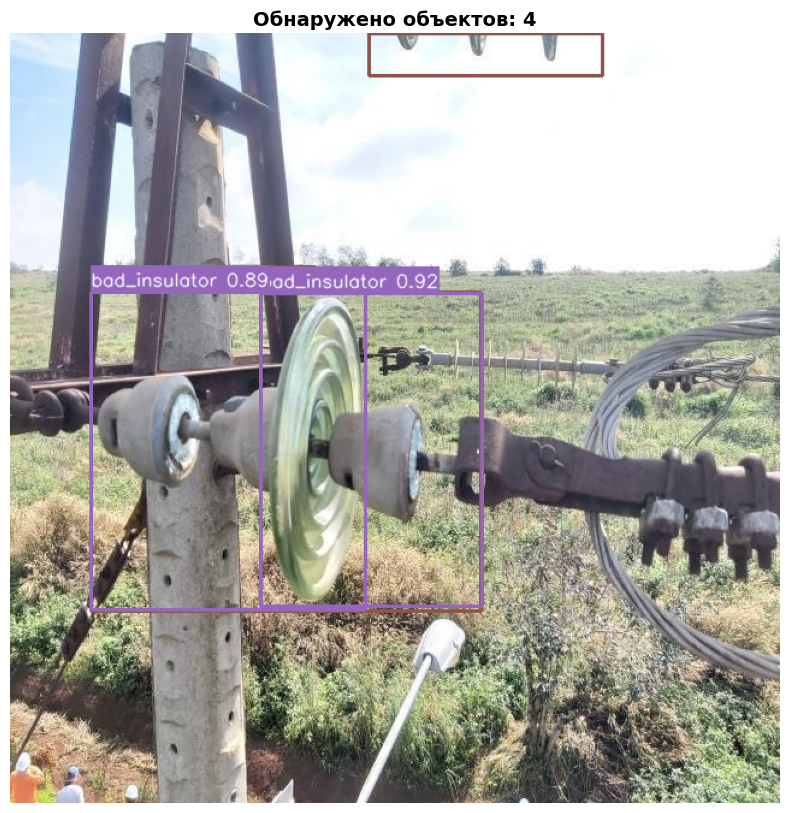

Найдено объектов: 4

Обрабатываем: 20221210_093305_jpg.rf.1ca3fc44dcdc31edd339a777dcbec2d4.jpg

image 1/1 c:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\20221210_093305_jpg.rf.1ca3fc44dcdc31edd339a777dcbec2d4.jpg: 480x480 2 festoon_insulatorss, 2 bad_insulators, 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 480)


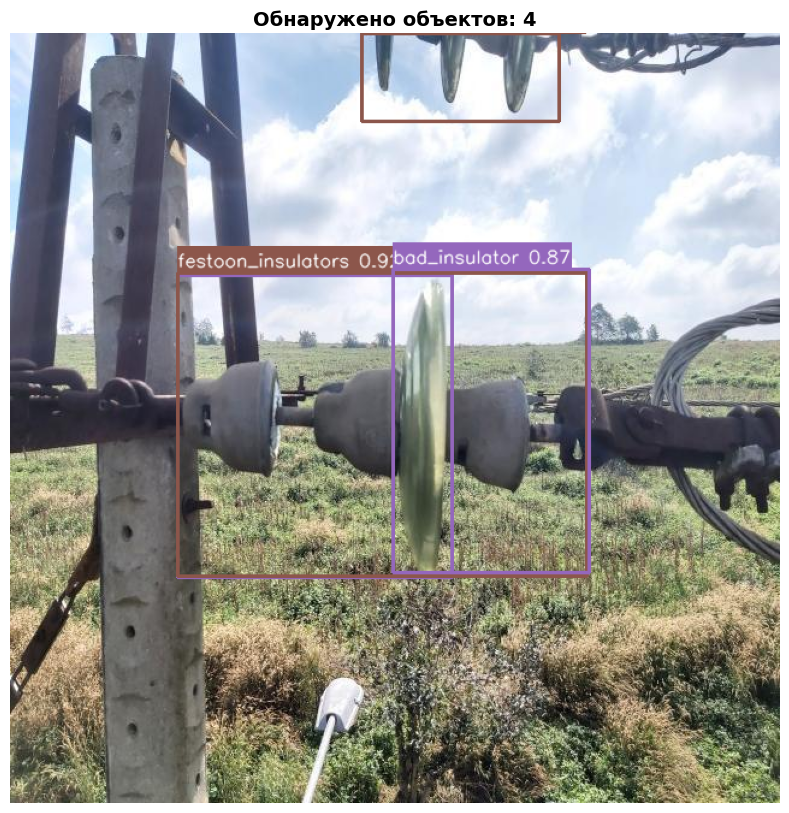

Найдено объектов: 4

Обрабатываем: 20221210_093321_jpg.rf.1e55b577e3e22d7808d9b2a9da521334.jpg

image 1/1 c:\Users\HappyUser\Desktop\ai\insulators_yolo\val\images\20221210_093321_jpg.rf.1e55b577e3e22d7808d9b2a9da521334.jpg: 480x480 2 festoon_insulatorss, 2 traverses, 1 bad_insulator, 1 damaged_insulator, 27.8ms
Speed: 1.3ms preprocess, 27.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 480)


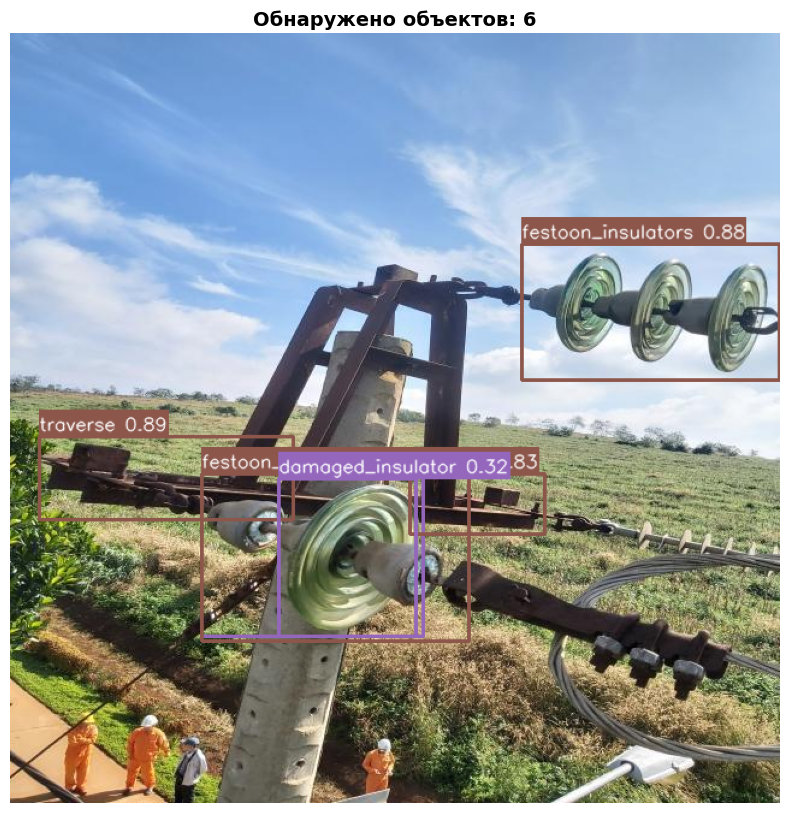

Найдено объектов: 6



In [24]:
val_images = list((YOLO_DIR / 'val' / 'images').glob('*.jpg'))[:5]

print(f"Тестирование на {len(val_images)} изображениях...\n")

for img_path in val_images:
    print(f"Обрабатываем: {img_path.name}")

    # Предсказание
    results = best_model.predict(str(img_path), conf=0.25, iou=0.45)

    # Извлекаем результаты
    predictions = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0].cpu().numpy())
            cls = int(box.cls[0].cpu().numpy())
            class_name = result.names[cls]

            predictions.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': conf,
                'class': class_name
            })

    # Визуализируем
    visualize_predictions(img_path, predictions)
    print(f"Найдено объектов: {len(predictions)}\n")

In [25]:
print(f"PyTorch: {best_model_path}")

# ONNX формат (для развертывания)
try:
    onnx_path = best_model.export(format='onnx')
    print(f"ONNX: {onnx_path}")
except Exception as e:
    print(f"Не удалось экспортировать в ONNX: {e}")


PyTorch: runs\detect\insulator_detection\weights\best.pt
Ultralytics 8.3.229  Python-3.12.10 torch-2.5.1+cu121 CPU (12th Gen Intel Core i5-12400F)

PyTorch: starting from 'C:\Users\HappyUser\Desktop\ai\runs\detect\insulator_augmented\weights\best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 12, 4725) (49.6 MB)

ONNX: starting export with onnx 1.19.1 opset 19...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success  2.5s, saved as 'C:\Users\HappyUser\Desktop\ai\runs\detect\insulator_augmented\weights\best.onnx' (98.8 MB)

Export complete (2.9s)
Results saved to C:\Users\HappyUser\Desktop\ai\runs\detect\insulator_augmented\weights
Predict:         yolo predict task=detect model=C:\Users\HappyUser\Desktop\ai\runs\detect\insulator_augmented\weights\best.onnx imgsz=480  
Validate:        yolo val task=detect model=C:\Users\HappyUser\Desktop\ai\runs\detect\insulator_augmented\weights\best.onnx imgsz=480 data=insulators_yolo_augmented\data.yaml  
Visualize:       h

In [ ]:
def detect_objects(image_path, model_path=None, conf_threshold=0.25):
    """
    Функция для детекции объектов на изображении

    Args:
        image_path: путь к изображению
        model_path: путь к модели (если None - используется лучшая)
        conf_threshold: порог уверенности (0-1)

    Returns:
        list: список обнаруженных объектов с координатами и классами
    """
    # Загружаем модель
    if model_path is None:
        model_path = 'runs/detect/insulator_detection/weights/best.pt'

    model = YOLO(model_path)

    # Предсказание
    results = model.predict(image_path, conf=conf_threshold, iou=0.45, verbose=False)

    # Парсим результаты
    detections = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().tolist()
            conf = float(box.conf[0].cpu().numpy())
            cls = int(box.cls[0].cpu().numpy())
            class_name = result.names[cls]

            detections.append({
                'class': class_name,
                'confidence': round(conf, 3),
                'bbox': {
                    'x1': round(x1, 2),
                    'y1': round(y1, 2),
                    'x2': round(x2, 2),
                    'y2': round(y2, 2)
                }
            })

    return detections

In [ ]:
test_image = val_images[0]
detections = detect_objects(test_image)

print(f"\nИзображение: {test_image.name}")
print(f"Обнаружено объектов: {len(detections)}")
print("\nДетали:")
for i, det in enumerate(detections, 1):
    print(f"  {i}. {det['class']} (уверенность: {det['confidence']})")


📸 Изображение: 170903--2-_JPG.rf.174da06b77ffb1379a221a03ed3ed599.jpg
✅ Обнаружено объектов: 1

📋 Детали:
  1. nest (уверенность: 0.864)
